In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'scale',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_md_data_scale_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(734160, 828)
(734160, 1)
validation
(101248, 828)
(101248, 1)
test
(100432, 828)
(100432, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/74 [..............................] - ETA: 1:34 - loss: 0.0277 - STD: 1.7171e-04 - MAE: 0.1578

 4/74 [>.............................] - ETA: 1s - loss: 0.0236 - STD: 2.2171e-04 - MAE: 0.1160  

 5/74 [=>............................] - ETA: 2s - loss: 0.0231 - STD: 2.3595e-04 - MAE: 0.1119

 6/74 [=>............................] - ETA: 3s - loss: 0.0216 - STD: 2.6334e-04 - MAE: 0.1037

 7/74 [=>............................] - ETA: 3s - loss: 0.0202 - STD: 3.0285e-04 - MAE: 0.0989

 8/74 [==>...........................] - ETA: 3s - loss: 0.0195 - STD: 3.4813e-04 - MAE: 0.0991

 9/74 [==>...........................] - ETA: 3s - loss: 0.0193 - STD: 3.9650e-04 - MAE: 0.1012

10/74 [===>..........................] - ETA: 3s - loss: 0.0190 - STD: 4.4258e-04 - MAE: 0.1025

11/74 [===>..........................] - ETA: 3s - loss: 0.0186 - STD: 4.8376e-04 - MAE: 0.1020

12/74 [===>..........................] - ETA: 3s - loss: 0.0180 - STD: 5.1904e-04 - MAE: 0.0999

13/74 [====>.........................] - ETA: 3s - loss: 0.0176 - STD: 5.4920e-04 - MAE: 0.0972

14/74 [====>.........................] - ETA: 3s - loss: 0.0173 - STD: 5.7461e-04 - MAE: 0.0946

15/74 [=====>........................] - ETA: 3s - loss: 0.0171 - STD: 5.9783e-04 - MAE: 0.0925

16/74 [=====>........................] - ETA: 5s - loss: 0.0170 - STD: 6.2044e-04 - MAE: 0.0906

19/74 [======>.......................] - ETA: 4s - loss: 0.0164 - STD: 7.0192e-04 - MAE: 0.0859

21/74 [=======>......................] - ETA: 4s - loss: 0.0159 - STD: 7.7207e-04 - MAE: 0.0846

22/74 [=======>......................] - ETA: 3s - loss: 0.0158 - STD: 8.1112e-04 - MAE: 0.0846

23/74 [========>.....................] - ETA: 3s - loss: 0.0156 - STD: 8.5049e-04 - MAE: 0.0847

24/74 [========>.....................] - ETA: 3s - loss: 0.0155 - STD: 8.9063e-04 - MAE: 0.0848

25/74 [=========>....................] - ETA: 3s - loss: 0.0154 - STD: 9.2956e-04 - MAE: 0.0846

26/74 [=========>....................] - ETA: 3s - loss: 0.0152 - STD: 9.6816e-04 - MAE: 0.0842

27/74 [=========>....................] - ETA: 3s - loss: 0.0151 - STD: 0.0010 - MAE: 0.0836    

28/74 [==========>...................] - ETA: 3s - loss: 0.0150 - STD: 0.0010 - MAE: 0.0828

29/74 [==========>...................] - ETA: 3s - loss: 0.0149 - STD: 0.0011 - MAE: 0.0821

30/74 [===========>..................] - ETA: 3s - loss: 0.0148 - STD: 0.0011 - MAE: 0.0814

31/74 [===========>..................] - ETA: 3s - loss: 0.0147 - STD: 0.0012 - MAE: 0.0808

32/74 [===========>..................] - ETA: 3s - loss: 0.0146 - STD: 0.0012 - MAE: 0.0801

33/74 [============>.................] - ETA: 2s - loss: 0.0145 - STD: 0.0012 - MAE: 0.0796

34/74 [============>.................] - ETA: 2s - loss: 0.0144 - STD: 0.0013 - MAE: 0.0792

35/74 [=============>................] - ETA: 2s - loss: 0.0143 - STD: 0.0013 - MAE: 0.0790

36/74 [=============>................] - ETA: 2s - loss: 0.0143 - STD: 0.0014 - MAE: 0.0790

37/74 [==============>...............] - ETA: 2s - loss: 0.0142 - STD: 0.0015 - MAE: 0.0789

38/74 [==============>...............] - ETA: 2s - loss: 0.0141 - STD: 0.0015 - MAE: 0.0788

39/74 [==============>...............] - ETA: 2s - loss: 0.0141 - STD: 0.0016 - MAE: 0.0786

40/74 [===============>..............] - ETA: 2s - loss: 0.0140 - STD: 0.0017 - MAE: 0.0784

41/74 [===============>..............] - ETA: 2s - loss: 0.0139 - STD: 0.0017 - MAE: 0.0781

42/74 [================>.............] - ETA: 2s - loss: 0.0138 - STD: 0.0018 - MAE: 0.0777

43/74 [================>.............] - ETA: 2s - loss: 0.0138 - STD: 0.0019 - MAE: 0.0773

44/74 [================>.............] - ETA: 2s - loss: 0.0137 - STD: 0.0020 - MAE: 0.0769

45/74 [=================>............] - ETA: 2s - loss: 0.0136 - STD: 0.0021 - MAE: 0.0766

46/74 [=================>............] - ETA: 1s - loss: 0.0136 - STD: 0.0022 - MAE: 0.0763

47/74 [==================>...........] - ETA: 1s - loss: 0.0135 - STD: 0.0023 - MAE: 0.0760

48/74 [==================>...........] - ETA: 1s - loss: 0.0134 - STD: 0.0024 - MAE: 0.0758

49/74 [==================>...........] - ETA: 1s - loss: 0.0134 - STD: 0.0026 - MAE: 0.0756

50/74 [===================>..........] - ETA: 1s - loss: 0.0133 - STD: 0.0027 - MAE: 0.0755

51/74 [===================>..........] - ETA: 1s - loss: 0.0133 - STD: 0.0029 - MAE: 0.0754

52/74 [====================>.........] - ETA: 1s - loss: 0.0132 - STD: 0.0030 - MAE: 0.0752

53/74 [====================>.........] - ETA: 1s - loss: 0.0132 - STD: 0.0032 - MAE: 0.0750

54/74 [====================>.........] - ETA: 1s - loss: 0.0131 - STD: 0.0034 - MAE: 0.0748

55/74 [=====================>........] - ETA: 1s - loss: 0.0131 - STD: 0.0036 - MAE: 0.0746

56/74 [=====================>........] - ETA: 1s - loss: 0.0130 - STD: 0.0039 - MAE: 0.0743

57/74 [======================>.......] - ETA: 1s - loss: 0.0130 - STD: 0.0041 - MAE: 0.0741

58/74 [======================>.......] - ETA: 1s - loss: 0.0129 - STD: 0.0044 - MAE: 0.0738

59/74 [======================>.......] - ETA: 1s - loss: 0.0128 - STD: 0.0048 - MAE: 0.0736

60/74 [=======================>......] - ETA: 0s - loss: 0.0128 - STD: 0.0051 - MAE: 0.0734

61/74 [=======================>......] - ETA: 0s - loss: 0.0127 - STD: 0.0055 - MAE: 0.0731

62/74 [========================>.....] - ETA: 0s - loss: 0.0126 - STD: 0.0060 - MAE: 0.0729

63/74 [========================>.....] - ETA: 0s - loss: 0.0126 - STD: 0.0065 - MAE: 0.0726

64/74 [========================>.....] - ETA: 0s - loss: 0.0125 - STD: 0.0070 - MAE: 0.0723

65/74 [=========================>....] - ETA: 0s - loss: 0.0124 - STD: 0.0075 - MAE: 0.0720

66/74 [=========================>....] - ETA: 0s - loss: 0.0123 - STD: 0.0081 - MAE: 0.0717

67/74 [==========================>...] - ETA: 0s - loss: 0.0122 - STD: 0.0088 - MAE: 0.0713

68/74 [==========================>...] - ETA: 0s - loss: 0.0121 - STD: 0.0095 - MAE: 0.0710

69/74 [==========================>...] - ETA: 0s - loss: 0.0121 - STD: 0.0103 - MAE: 0.0707

70/74 [===========================>..] - ETA: 0s - loss: 0.0120 - STD: 0.0111 - MAE: 0.0705

71/74 [===========================>..] - ETA: 0s - loss: 0.0119 - STD: 0.0120 - MAE: 0.0702

72/74 [============================>.] - ETA: 0s - loss: 0.0118 - STD: 0.0128 - MAE: 0.0699

73/74 [============================>.] - ETA: 0s - loss: 0.0117 - STD: 0.0137 - MAE: 0.0695

74/74 [==============================] - ETA: 0s - loss: 0.0116 - STD: 0.0145 - MAE: 0.0692

74/74 [==============================] - 7s 77ms/step - loss: 0.0116 - STD: 0.0145 - MAE: 0.0692 - val_loss: 0.0047 - val_STD: 0.0521 - val_MAE: 0.0428


Epoch 2/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0047 - STD: 0.0795 - MAE: 0.0454

 2/74 [..............................] - ETA: 5s - loss: 0.0045 - STD: 0.0804 - MAE: 0.0448

 3/74 [>.............................] - ETA: 5s - loss: 0.0045 - STD: 0.0819 - MAE: 0.0447

 4/74 [>.............................] - ETA: 5s - loss: 0.0044 - STD: 0.0823 - MAE: 0.0441

 5/74 [=>............................] - ETA: 4s - loss: 0.0043 - STD: 0.0820 - MAE: 0.0437

 6/74 [=>............................] - ETA: 4s - loss: 0.0043 - STD: 0.0816 - MAE: 0.0431

 7/74 [=>............................] - ETA: 4s - loss: 0.0042 - STD: 0.0815 - MAE: 0.0427

 8/74 [==>...........................] - ETA: 4s - loss: 0.0042 - STD: 0.0816 - MAE: 0.0424

 9/74 [==>...........................] - ETA: 4s - loss: 0.0041 - STD: 0.0818 - MAE: 0.0422

10/74 [===>..........................] - ETA: 4s - loss: 0.0040 - STD: 0.0823 - MAE: 0.0418

11/74 [===>..........................] - ETA: 4s - loss: 0.0040 - STD: 0.0825 - MAE: 0.0415

12/74 [===>..........................] - ETA: 4s - loss: 0.0040 - STD: 0.0829 - MAE: 0.0413

13/74 [====>.........................] - ETA: 4s - loss: 0.0039 - STD: 0.0835 - MAE: 0.0410

14/74 [====>.........................] - ETA: 4s - loss: 0.0039 - STD: 0.0841 - MAE: 0.0408

15/74 [=====>........................] - ETA: 4s - loss: 0.0038 - STD: 0.0849 - MAE: 0.0406

16/74 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0857 - MAE: 0.0404

17/74 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0863 - MAE: 0.0402

18/74 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0868 - MAE: 0.0401

19/74 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0873 - MAE: 0.0399

20/74 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0876 - MAE: 0.0397

21/74 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0879 - MAE: 0.0395

22/74 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0882 - MAE: 0.0394

23/74 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0884 - MAE: 0.0393

24/74 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0886 - MAE: 0.0391

25/74 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0887 - MAE: 0.0390

26/74 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0889 - MAE: 0.0388

27/74 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0891 - MAE: 0.0387

28/74 [==========>...................] - ETA: 3s - loss: 0.0035 - STD: 0.0895 - MAE: 0.0386

29/74 [==========>...................] - ETA: 3s - loss: 0.0035 - STD: 0.0898 - MAE: 0.0385

30/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0900 - MAE: 0.0384

31/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0901 - MAE: 0.0383

32/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0904 - MAE: 0.0382

33/74 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0907 - MAE: 0.0381

34/74 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0909 - MAE: 0.0381

35/74 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0909 - MAE: 0.0379

36/74 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0909 - MAE: 0.0379

37/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0909 - MAE: 0.0378

38/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0911 - MAE: 0.0377

39/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0912 - MAE: 0.0377

40/74 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0913 - MAE: 0.0376

41/74 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0913 - MAE: 0.0375

42/74 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0915 - MAE: 0.0374

43/74 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0916 - MAE: 0.0374

44/74 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0918 - MAE: 0.0373

45/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0919 - MAE: 0.0373

46/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0920 - MAE: 0.0372

47/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0920 - MAE: 0.0372

48/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0921 - MAE: 0.0371

49/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0922 - MAE: 0.0371

50/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0922 - MAE: 0.0370

51/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0922 - MAE: 0.0369

52/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0922 - MAE: 0.0369

53/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0923 - MAE: 0.0368

54/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0924 - MAE: 0.0368

55/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0924 - MAE: 0.0367

56/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0925 - MAE: 0.0367

57/74 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0926 - MAE: 0.0367

58/74 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0927 - MAE: 0.0366

59/74 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0927 - MAE: 0.0366

60/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0928 - MAE: 0.0365

61/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0928 - MAE: 0.0365

62/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0929 - MAE: 0.0364

63/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0929 - MAE: 0.0364

64/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0930 - MAE: 0.0363

65/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0931 - MAE: 0.0363

66/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0931 - MAE: 0.0363

67/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0931 - MAE: 0.0362

68/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0932 - MAE: 0.0362

70/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0933 - MAE: 0.0361

71/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0934 - MAE: 0.0361

72/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0934 - MAE: 0.0360

73/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0934 - MAE: 0.0360

74/74 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0935 - MAE: 0.0359

74/74 [==============================] - 5s 70ms/step - loss: 0.0030 - STD: 0.0935 - MAE: 0.0359 - val_loss: 0.0029 - val_STD: 0.0661 - val_MAE: 0.0317


Epoch 3/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0025 - STD: 0.0942 - MAE: 0.0323

 2/74 [..............................] - ETA: 4s - loss: 0.0024 - STD: 0.0933 - MAE: 0.0323

 4/74 [>.............................] - ETA: 3s - loss: 0.0024 - STD: 0.0955 - MAE: 0.0327

 5/74 [=>............................] - ETA: 4s - loss: 0.0024 - STD: 0.0954 - MAE: 0.0326

 6/74 [=>............................] - ETA: 4s - loss: 0.0024 - STD: 0.0955 - MAE: 0.0327

 7/74 [=>............................] - ETA: 4s - loss: 0.0024 - STD: 0.0960 - MAE: 0.0326

 8/74 [==>...........................] - ETA: 4s - loss: 0.0025 - STD: 0.0962 - MAE: 0.0327

 9/74 [==>...........................] - ETA: 4s - loss: 0.0024 - STD: 0.0964 - MAE: 0.0327

10/74 [===>..........................] - ETA: 4s - loss: 0.0025 - STD: 0.0964 - MAE: 0.0328

11/74 [===>..........................] - ETA: 4s - loss: 0.0025 - STD: 0.0964 - MAE: 0.0328

12/74 [===>..........................] - ETA: 3s - loss: 0.0025 - STD: 0.0968 - MAE: 0.0327

13/74 [====>.........................] - ETA: 3s - loss: 0.0025 - STD: 0.0967 - MAE: 0.0327

14/74 [====>.........................] - ETA: 3s - loss: 0.0025 - STD: 0.0966 - MAE: 0.0327

15/74 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.0965 - MAE: 0.0327

16/74 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.0966 - MAE: 0.0327

17/74 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.0967 - MAE: 0.0327

18/74 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0966 - MAE: 0.0327

19/74 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0966 - MAE: 0.0327

20/74 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0967 - MAE: 0.0327

21/74 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0968 - MAE: 0.0326

22/74 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0968 - MAE: 0.0326

23/74 [========>.....................] - ETA: 3s - loss: 0.0025 - STD: 0.0968 - MAE: 0.0326

24/74 [========>.....................] - ETA: 3s - loss: 0.0025 - STD: 0.0970 - MAE: 0.0326

25/74 [=========>....................] - ETA: 3s - loss: 0.0025 - STD: 0.0971 - MAE: 0.0326

26/74 [=========>....................] - ETA: 3s - loss: 0.0025 - STD: 0.0972 - MAE: 0.0326

27/74 [=========>....................] - ETA: 3s - loss: 0.0025 - STD: 0.0971 - MAE: 0.0325

28/74 [==========>...................] - ETA: 3s - loss: 0.0024 - STD: 0.0971 - MAE: 0.0325

29/74 [==========>...................] - ETA: 2s - loss: 0.0024 - STD: 0.0969 - MAE: 0.0325

30/74 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.0970 - MAE: 0.0325

31/74 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.0971 - MAE: 0.0324

32/74 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.0970 - MAE: 0.0324

33/74 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.0970 - MAE: 0.0324

34/74 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.0970 - MAE: 0.0324

35/74 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.0970 - MAE: 0.0324

36/74 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.0971 - MAE: 0.0324

37/74 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.0970 - MAE: 0.0323

38/74 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.0971 - MAE: 0.0323

39/74 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.0971 - MAE: 0.0323

40/74 [===============>..............] - ETA: 2s - loss: 0.0024 - STD: 0.0970 - MAE: 0.0323

41/74 [===============>..............] - ETA: 2s - loss: 0.0024 - STD: 0.0970 - MAE: 0.0323

42/74 [================>.............] - ETA: 2s - loss: 0.0024 - STD: 0.0970 - MAE: 0.0323

43/74 [================>.............] - ETA: 2s - loss: 0.0024 - STD: 0.0970 - MAE: 0.0322

44/74 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.0971 - MAE: 0.0322

45/74 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.0971 - MAE: 0.0322

46/74 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.0971 - MAE: 0.0322

47/74 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0971 - MAE: 0.0322

48/74 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0971 - MAE: 0.0322

49/74 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0972 - MAE: 0.0321

50/74 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0972 - MAE: 0.0321

51/74 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0972 - MAE: 0.0321

52/74 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0972 - MAE: 0.0321

53/74 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0972 - MAE: 0.0321

54/74 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0972 - MAE: 0.0321

55/74 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0972 - MAE: 0.0320

56/74 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0972 - MAE: 0.0320

57/74 [======================>.......] - ETA: 1s - loss: 0.0024 - STD: 0.0972 - MAE: 0.0320

58/74 [======================>.......] - ETA: 1s - loss: 0.0024 - STD: 0.0973 - MAE: 0.0320

60/74 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0973 - MAE: 0.0320

61/74 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0973 - MAE: 0.0319

62/74 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0973 - MAE: 0.0319

63/74 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0973 - MAE: 0.0319

64/74 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0973 - MAE: 0.0319

65/74 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0973 - MAE: 0.0318

66/74 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0973 - MAE: 0.0318

67/74 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0973 - MAE: 0.0318

68/74 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0973 - MAE: 0.0318

69/74 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0973 - MAE: 0.0318

70/74 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0973 - MAE: 0.0318

71/74 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0973 - MAE: 0.0317

72/74 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0973 - MAE: 0.0317

73/74 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0973 - MAE: 0.0317

74/74 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.0973 - MAE: 0.0317

74/74 [==============================] - 5s 70ms/step - loss: 0.0023 - STD: 0.0973 - MAE: 0.0317 - val_loss: 0.0028 - val_STD: 0.0732 - val_MAE: 0.0319


Epoch 4/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0023 - STD: 0.1015 - MAE: 0.0314

 2/74 [..............................] - ETA: 4s - loss: 0.0022 - STD: 0.1000 - MAE: 0.0312

 3/74 [>.............................] - ETA: 5s - loss: 0.0022 - STD: 0.0998 - MAE: 0.0307

 4/74 [>.............................] - ETA: 4s - loss: 0.0022 - STD: 0.0999 - MAE: 0.0307

 5/74 [=>............................] - ETA: 4s - loss: 0.0022 - STD: 0.0981 - MAE: 0.0306

 6/74 [=>............................] - ETA: 4s - loss: 0.0022 - STD: 0.0977 - MAE: 0.0305

 7/74 [=>............................] - ETA: 4s - loss: 0.0022 - STD: 0.0975 - MAE: 0.0307

 8/74 [==>...........................] - ETA: 4s - loss: 0.0022 - STD: 0.0970 - MAE: 0.0307

 9/74 [==>...........................] - ETA: 4s - loss: 0.0022 - STD: 0.0972 - MAE: 0.0307

10/74 [===>..........................] - ETA: 4s - loss: 0.0022 - STD: 0.0975 - MAE: 0.0307

11/74 [===>..........................] - ETA: 4s - loss: 0.0022 - STD: 0.0974 - MAE: 0.0306

12/74 [===>..........................] - ETA: 4s - loss: 0.0022 - STD: 0.0975 - MAE: 0.0306

13/74 [====>.........................] - ETA: 4s - loss: 0.0022 - STD: 0.0975 - MAE: 0.0306

14/74 [====>.........................] - ETA: 4s - loss: 0.0022 - STD: 0.0973 - MAE: 0.0305

15/74 [=====>........................] - ETA: 3s - loss: 0.0022 - STD: 0.0972 - MAE: 0.0305

16/74 [=====>........................] - ETA: 3s - loss: 0.0022 - STD: 0.0974 - MAE: 0.0305

17/74 [=====>........................] - ETA: 3s - loss: 0.0022 - STD: 0.0973 - MAE: 0.0305

18/74 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.0974 - MAE: 0.0305

19/74 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.0974 - MAE: 0.0306

20/74 [=======>......................] - ETA: 3s - loss: 0.0022 - STD: 0.0974 - MAE: 0.0305

21/74 [=======>......................] - ETA: 3s - loss: 0.0022 - STD: 0.0974 - MAE: 0.0305

22/74 [=======>......................] - ETA: 3s - loss: 0.0022 - STD: 0.0974 - MAE: 0.0305

23/74 [========>.....................] - ETA: 3s - loss: 0.0022 - STD: 0.0974 - MAE: 0.0304

24/74 [========>.....................] - ETA: 3s - loss: 0.0022 - STD: 0.0975 - MAE: 0.0304

25/74 [=========>....................] - ETA: 3s - loss: 0.0022 - STD: 0.0975 - MAE: 0.0304

26/74 [=========>....................] - ETA: 3s - loss: 0.0022 - STD: 0.0976 - MAE: 0.0303

27/74 [=========>....................] - ETA: 3s - loss: 0.0022 - STD: 0.0977 - MAE: 0.0303

28/74 [==========>...................] - ETA: 3s - loss: 0.0022 - STD: 0.0977 - MAE: 0.0303

29/74 [==========>...................] - ETA: 2s - loss: 0.0022 - STD: 0.0979 - MAE: 0.0303

30/74 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.0980 - MAE: 0.0303

31/74 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.0981 - MAE: 0.0303

32/74 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.0982 - MAE: 0.0303

33/74 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.0982 - MAE: 0.0303

34/74 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.0981 - MAE: 0.0303

35/74 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.0983 - MAE: 0.0303

36/74 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.0983 - MAE: 0.0302

37/74 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.0982 - MAE: 0.0302

38/74 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.0983 - MAE: 0.0302

39/74 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.0982 - MAE: 0.0302

40/74 [===============>..............] - ETA: 2s - loss: 0.0021 - STD: 0.0983 - MAE: 0.0302

41/74 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.0983 - MAE: 0.0302

42/74 [================>.............] - ETA: 2s - loss: 0.0021 - STD: 0.0983 - MAE: 0.0302

43/74 [================>.............] - ETA: 2s - loss: 0.0021 - STD: 0.0983 - MAE: 0.0302

44/74 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.0984 - MAE: 0.0302

45/74 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.0984 - MAE: 0.0302

46/74 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.0985 - MAE: 0.0302

47/74 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.0985 - MAE: 0.0302

48/74 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.0984 - MAE: 0.0301

49/74 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.0985 - MAE: 0.0301

50/74 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.0984 - MAE: 0.0301

51/74 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.0985 - MAE: 0.0301

52/74 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.0985 - MAE: 0.0301

53/74 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.0985 - MAE: 0.0301

54/74 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.0985 - MAE: 0.0301

55/74 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.0985 - MAE: 0.0301

56/74 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.0985 - MAE: 0.0301

57/74 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.0986 - MAE: 0.0301

58/74 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.0985 - MAE: 0.0301

59/74 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.0986 - MAE: 0.0301

60/74 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0986 - MAE: 0.0301

61/74 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0985 - MAE: 0.0301

63/74 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0986 - MAE: 0.0301

64/74 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0986 - MAE: 0.0301

65/74 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0986 - MAE: 0.0301

66/74 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0986 - MAE: 0.0300

67/74 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0986 - MAE: 0.0300

68/74 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0986 - MAE: 0.0301

69/74 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0986 - MAE: 0.0301

70/74 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0986 - MAE: 0.0301

71/74 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0986 - MAE: 0.0301

72/74 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0987 - MAE: 0.0301

73/74 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0987 - MAE: 0.0301

74/74 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.0987 - MAE: 0.0301

74/74 [==============================] - 5s 70ms/step - loss: 0.0021 - STD: 0.0987 - MAE: 0.0301 - val_loss: 0.0029 - val_STD: 0.0719 - val_MAE: 0.0316


Epoch 5/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0019 - STD: 0.0989 - MAE: 0.0287

 2/74 [..............................] - ETA: 5s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0293

 3/74 [>.............................] - ETA: 5s - loss: 0.0020 - STD: 0.0999 - MAE: 0.0295

 4/74 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0294

 5/74 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0293

 6/74 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.1000 - MAE: 0.0294

 7/74 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0294

 8/74 [==>...........................] - ETA: 4s - loss: 0.0020 - STD: 0.0998 - MAE: 0.0294

 9/74 [==>...........................] - ETA: 4s - loss: 0.0020 - STD: 0.0999 - MAE: 0.0294

10/74 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0295

11/74 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.0999 - MAE: 0.0297

12/74 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0297

14/74 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.0999 - MAE: 0.0298

15/74 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.0995 - MAE: 0.0299

16/74 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.0996 - MAE: 0.0299

17/74 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.0995 - MAE: 0.0299

18/74 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0299

19/74 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0300

20/74 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0299

21/74 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0299

22/74 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0299

23/74 [========>.....................] - ETA: 3s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0299

24/74 [========>.....................] - ETA: 3s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0299

25/74 [=========>....................] - ETA: 3s - loss: 0.0021 - STD: 0.0994 - MAE: 0.0299

26/74 [=========>....................] - ETA: 3s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0299

27/74 [=========>....................] - ETA: 3s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0299

28/74 [==========>...................] - ETA: 3s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0299

29/74 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0299

30/74 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0298

31/74 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0994 - MAE: 0.0298

32/74 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0299

33/74 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0299

34/74 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0299

35/74 [=============>................] - ETA: 2s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0299

36/74 [=============>................] - ETA: 2s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0299

37/74 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0298

38/74 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0298

39/74 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0992 - MAE: 0.0298

40/74 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.0992 - MAE: 0.0298

41/74 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0297

42/74 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0297

43/74 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.0992 - MAE: 0.0297

44/74 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.0992 - MAE: 0.0297

45/74 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.0992 - MAE: 0.0297

46/74 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.0992 - MAE: 0.0297

47/74 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.0992 - MAE: 0.0296

48/74 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0296

49/74 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0296

50/74 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0296

51/74 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0296

52/74 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0296

53/74 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0296

54/74 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0296

55/74 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0296

56/74 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0296

57/74 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0296

58/74 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0296

59/74 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0296

60/74 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0296

61/74 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0296

62/74 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0295

63/74 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0295

64/74 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0296

65/74 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0296

66/74 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0296

67/74 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0296

68/74 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0295

69/74 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0295

70/74 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0295

71/74 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0295

72/74 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0295

73/74 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0295

74/74 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0295

74/74 [==============================] - 5s 70ms/step - loss: 0.0020 - STD: 0.0994 - MAE: 0.0295 - val_loss: 0.0027 - val_STD: 0.0749 - val_MAE: 0.0320


Epoch 6/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0299

 2/74 [..............................] - ETA: 5s - loss: 0.0020 - STD: 0.1011 - MAE: 0.0295

 3/74 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0292

 4/74 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.1003 - MAE: 0.0292

 5/74 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0295

 6/74 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0298

 7/74 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0297

 8/74 [==>...........................] - ETA: 4s - loss: 0.0020 - STD: 0.0991 - MAE: 0.0296

 9/74 [==>...........................] - ETA: 4s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0298

10/74 [===>..........................] - ETA: 4s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0298

11/74 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0298

12/74 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0297

13/74 [====>.........................] - ETA: 4s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0297

14/74 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0298

15/74 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0298

16/74 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0297

17/74 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0298

18/74 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0298

19/74 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0297

21/74 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0297

22/74 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0298

23/74 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0297

24/74 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0297

25/74 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0297

26/74 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0297

27/74 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0297

28/74 [==========>...................] - ETA: 3s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0297

29/74 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0296

30/74 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0296

31/74 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0296

32/74 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0296

33/74 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0296

34/74 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0295

35/74 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0295

36/74 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0295

37/74 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0295

38/74 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0295

39/74 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0295

40/74 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0295

41/74 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0295

42/74 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0295

43/74 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0295

44/74 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0295

45/74 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0294

46/74 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0294

47/74 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0294

48/74 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0294

49/74 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0294

50/74 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0294

51/74 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0294

52/74 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0293

53/74 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0293

54/74 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0293

55/74 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0293

56/74 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0293

57/74 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0293

58/74 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0293

59/74 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0293

60/74 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0292

61/74 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0292

62/74 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0292

63/74 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0292

64/74 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0998 - MAE: 0.0292

65/74 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0998 - MAE: 0.0292

66/74 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0998 - MAE: 0.0292

67/74 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0998 - MAE: 0.0292

68/74 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0998 - MAE: 0.0292

69/74 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0292

70/74 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0998 - MAE: 0.0292

71/74 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0291

72/74 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0291

73/74 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0291

74/74 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.0998 - MAE: 0.0291

74/74 [==============================] - 5s 71ms/step - loss: 0.0020 - STD: 0.0998 - MAE: 0.0291 - val_loss: 0.0027 - val_STD: 0.0745 - val_MAE: 0.0312


Epoch 7/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0019 - STD: 0.1011 - MAE: 0.0286

 2/74 [..............................] - ETA: 5s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0287

 3/74 [>.............................] - ETA: 5s - loss: 0.0019 - STD: 0.1014 - MAE: 0.0293

 4/74 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0295

 5/74 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.1000 - MAE: 0.0296

 6/74 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0294

 8/74 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0292

 9/74 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0291

10/74 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0290

11/74 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0290

12/74 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0289

13/74 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0289

14/74 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0289

15/74 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0289

16/74 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0289

17/74 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0288

18/74 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0289

19/74 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.0994 - MAE: 0.0289

20/74 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.0994 - MAE: 0.0289

21/74 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0289

22/74 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.0994 - MAE: 0.0290

23/74 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0291

24/74 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.0995 - MAE: 0.0291

25/74 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.0995 - MAE: 0.0290

26/74 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0291

27/74 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0291

28/74 [==========>...................] - ETA: 3s - loss: 0.0019 - STD: 0.0995 - MAE: 0.0291

29/74 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0291

30/74 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.0995 - MAE: 0.0291

31/74 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.0995 - MAE: 0.0291

32/74 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.0995 - MAE: 0.0291

33/74 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.0995 - MAE: 0.0291

34/74 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.0995 - MAE: 0.0291

35/74 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.0995 - MAE: 0.0291

36/74 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.0994 - MAE: 0.0291

37/74 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.0995 - MAE: 0.0291

38/74 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.0994 - MAE: 0.0291

39/74 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.0994 - MAE: 0.0291

40/74 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.0995 - MAE: 0.0291

41/74 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.0995 - MAE: 0.0291

42/74 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0292

43/74 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0292

44/74 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0291

45/74 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0291

46/74 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0291

47/74 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0292

48/74 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0291

49/74 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0291

50/74 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0291

51/74 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0291

52/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0291

53/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0291

54/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0291

55/74 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0290

56/74 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0290

57/74 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0290

58/74 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0290

59/74 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0290

60/74 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0290

61/74 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0290

62/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0290

63/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0290

64/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0290

65/74 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0290

66/74 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0291

67/74 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0291

68/74 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0291

69/74 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0291

70/74 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0290

71/74 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0290

72/74 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0290

73/74 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0290

74/74 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0290

74/74 [==============================] - 5s 70ms/step - loss: 0.0019 - STD: 0.1000 - MAE: 0.0290 - val_loss: 0.0026 - val_STD: 0.0744 - val_MAE: 0.0309


Epoch 8/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0020 - STD: 0.1011 - MAE: 0.0293

 2/74 [..............................] - ETA: 5s - loss: 0.0020 - STD: 0.1011 - MAE: 0.0290

 3/74 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.1010 - MAE: 0.0287

 4/74 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0285

 5/74 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0284

 6/74 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0284

 7/74 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0284

 8/74 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0285

 9/74 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0285

11/74 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0288

12/74 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0289

13/74 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0289

14/74 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0289

15/74 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0289

16/74 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0290

17/74 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1007 - MAE: 0.0290

18/74 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.1007 - MAE: 0.0289

19/74 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0289

20/74 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0290

21/74 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0290

22/74 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0290

23/74 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0290

24/74 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0290

25/74 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0291

26/74 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0291

27/74 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0291

28/74 [==========>...................] - ETA: 3s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0291

29/74 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0291

30/74 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0291

31/74 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0291

32/74 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0291

33/74 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0291

34/74 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0290

35/74 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0290

36/74 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0290

37/74 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0290

38/74 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0289

39/74 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0289

40/74 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0289

41/74 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0289

42/74 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0289

43/74 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0289

44/74 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0289

45/74 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0289

46/74 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0289

47/74 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0289

48/74 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0289

49/74 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0289

50/74 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0289

51/74 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0289

52/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0289

53/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0289

54/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0289

55/74 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0289

56/74 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0289

57/74 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0289

58/74 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0289

59/74 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0288

60/74 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0288

61/74 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0288

62/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0288

63/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0288

64/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0288

65/74 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0288

66/74 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0288

67/74 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0288

68/74 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0288

69/74 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0288

70/74 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0288

71/74 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0288

72/74 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0288

73/74 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0288

74/74 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0288

74/74 [==============================] - 5s 70ms/step - loss: 0.0019 - STD: 0.1003 - MAE: 0.0288 - val_loss: 0.0028 - val_STD: 0.0726 - val_MAE: 0.0311


Epoch 9/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0019 - STD: 0.0958 - MAE: 0.0281

 2/74 [..............................] - ETA: 5s - loss: 0.0018 - STD: 0.0983 - MAE: 0.0280

 3/74 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0288

 4/74 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.0984 - MAE: 0.0296

 5/74 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.0999 - MAE: 0.0302

 6/74 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0298

 7/74 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0296

 8/74 [==>...........................] - ETA: 4s - loss: 0.0020 - STD: 0.0999 - MAE: 0.0297

 9/74 [==>...........................] - ETA: 4s - loss: 0.0020 - STD: 0.0999 - MAE: 0.0295

10/74 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.0998 - MAE: 0.0293

11/74 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.1001 - MAE: 0.0294

12/74 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.1000 - MAE: 0.0293

13/74 [====>.........................] - ETA: 4s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0292

14/74 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0292

15/74 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0293

16/74 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0292

17/74 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0292

18/74 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0292

19/74 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0292

20/74 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0292

21/74 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0292

22/74 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0291

23/74 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0292

24/74 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0291

25/74 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0291

26/74 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0291

27/74 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0290

28/74 [==========>...................] - ETA: 3s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0290

29/74 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0290

30/74 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0290

31/74 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0290

32/74 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0289

33/74 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0289

34/74 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0289

35/74 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0289

36/74 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0288

37/74 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0288

38/74 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0288

39/74 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0288

40/74 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0288

41/74 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0288

42/74 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0288

43/74 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0288

44/74 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0288

45/74 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0287

46/74 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0287

47/74 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0287

48/74 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0287

49/74 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0287

50/74 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0287

51/74 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0287

53/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0287

54/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0287

55/74 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0287

56/74 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0287

57/74 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0287

58/74 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0287

59/74 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0287

60/74 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0287

61/74 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0287

62/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0287

63/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0287

64/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0287

65/74 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0287

66/74 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0287

67/74 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0287

68/74 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0287

69/74 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0287

70/74 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0287

71/74 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0287

72/74 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0287

73/74 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0286

74/74 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0286

74/74 [==============================] - 5s 69ms/step - loss: 0.0019 - STD: 0.1003 - MAE: 0.0286 - val_loss: 0.0025 - val_STD: 0.0756 - val_MAE: 0.0309


Epoch 10/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0286

 2/74 [..............................] - ETA: 5s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0286

 3/74 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.0990 - MAE: 0.0283

 4/74 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0285

 5/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1001 - MAE: 0.0284

 6/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.0996 - MAE: 0.0283

 7/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.0999 - MAE: 0.0284

 8/74 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.1000 - MAE: 0.0284

 9/74 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.1000 - MAE: 0.0283

10/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1001 - MAE: 0.0284

11/74 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0284

12/74 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0285

13/74 [====>.........................] - ETA: 4s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0285

14/74 [====>.........................] - ETA: 4s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0284

15/74 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0285

16/74 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0285

17/74 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0285

18/74 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0285

19/74 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0285

20/74 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0285

21/74 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0285

22/74 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0285

23/74 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0285

24/74 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0285

25/74 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0285

26/74 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0285

27/74 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0285

28/74 [==========>...................] - ETA: 3s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0285

29/74 [==========>...................] - ETA: 3s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0285

30/74 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0285

31/74 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0284

32/74 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0284

33/74 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0284

34/74 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0284

35/74 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0284

36/74 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0284

37/74 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0284

38/74 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0284

39/74 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0285

40/74 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0284

41/74 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0285

43/74 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0285

44/74 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0285

45/74 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0285

46/74 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0285

47/74 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0286

48/74 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0285

49/74 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0285

50/74 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0286

51/74 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0286

52/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0286

53/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0286

54/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0286

55/74 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0286

56/74 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0286

57/74 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0287

58/74 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0287

59/74 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0287

60/74 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0287

61/74 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0287

62/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0287

63/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0287

64/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0287

65/74 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0287

66/74 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0287

67/74 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0287

68/74 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0287

69/74 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0287

70/74 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0287

71/74 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0287

72/74 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0287

73/74 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0286

74/74 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0286

74/74 [==============================] - 5s 70ms/step - loss: 0.0019 - STD: 0.1004 - MAE: 0.0286 - val_loss: 0.0025 - val_STD: 0.0779 - val_MAE: 0.0312


Epoch 11/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0294

 2/74 [..............................] - ETA: 5s - loss: 0.0020 - STD: 0.1041 - MAE: 0.0292

 3/74 [>.............................] - ETA: 5s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0289

 4/74 [>.............................] - ETA: 5s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0289

 5/74 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.1030 - MAE: 0.0288

 6/74 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.1027 - MAE: 0.0289

 7/74 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.1021 - MAE: 0.0289

 8/74 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.1014 - MAE: 0.0288

 9/74 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.1014 - MAE: 0.0288

10/74 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.1014 - MAE: 0.0287

11/74 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.1011 - MAE: 0.0286

12/74 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.1014 - MAE: 0.0286

13/74 [====>.........................] - ETA: 4s - loss: 0.0019 - STD: 0.1015 - MAE: 0.0286

14/74 [====>.........................] - ETA: 4s - loss: 0.0019 - STD: 0.1015 - MAE: 0.0285

15/74 [=====>........................] - ETA: 4s - loss: 0.0019 - STD: 0.1016 - MAE: 0.0285

16/74 [=====>........................] - ETA: 4s - loss: 0.0019 - STD: 0.1014 - MAE: 0.0285

17/74 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1013 - MAE: 0.0285

18/74 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.1013 - MAE: 0.0285

19/74 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.1012 - MAE: 0.0285

20/74 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.1014 - MAE: 0.0285

21/74 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.1014 - MAE: 0.0285

22/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0284

23/74 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1016 - MAE: 0.0285

24/74 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0284

25/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0284

26/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0284

27/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0284

28/74 [==========>...................] - ETA: 3s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0284

29/74 [==========>...................] - ETA: 3s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0284

30/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0284

31/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0284

32/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0284

33/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0284

34/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0283

35/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0283

36/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0283

37/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0283

38/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0283

39/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0283

40/74 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0283

41/74 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0282

42/74 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0282

43/74 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0283

44/74 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0282

45/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0282

46/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0283

47/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0283

48/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0283

49/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0283

50/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0283

51/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0283

52/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0283

53/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0283

54/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0283

55/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0283

56/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0283

57/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0283

58/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0283

59/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0283

60/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0283

61/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0283

62/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0283

63/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0283

64/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0283

65/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0283

66/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0283

67/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0283

68/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0283

69/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0283

70/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0283

71/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0282

72/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0283

73/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0282

74/74 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0282

74/74 [==============================] - 5s 72ms/step - loss: 0.0018 - STD: 0.1007 - MAE: 0.0282 - val_loss: 0.0025 - val_STD: 0.0769 - val_MAE: 0.0307


Epoch 12/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0019 - STD: 0.1010 - MAE: 0.0286

 2/74 [..............................] - ETA: 4s - loss: 0.0019 - STD: 0.1015 - MAE: 0.0284

 3/74 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.1023 - MAE: 0.0284

 4/74 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1019 - MAE: 0.0282

 5/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0280

 6/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0282

 7/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0283

 8/74 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0284

 9/74 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0283

10/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0283

11/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0283

12/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0283

13/74 [====>.........................] - ETA: 4s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0283

14/74 [====>.........................] - ETA: 3s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0283

15/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0282

16/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0283

17/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0283

18/74 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0283

19/74 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0283

20/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0284

21/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0284

22/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0284

23/74 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0283

24/74 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0284

25/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0285

26/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0285

27/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0285

28/74 [==========>...................] - ETA: 3s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0285

29/74 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0286

30/74 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0286

31/74 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0286

32/74 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0287

33/74 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0287

34/74 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0287

35/74 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0287

36/74 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0287

37/74 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0287

38/74 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0287

39/74 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0287

40/74 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0287

41/74 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0287

42/74 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0287

43/74 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0287

44/74 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0287

45/74 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0287

46/74 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0287

47/74 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0286

48/74 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0286

49/74 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0286

50/74 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0286

51/74 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0286

52/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0285

53/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0285

54/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0285

55/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0285

56/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0285

57/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0285

58/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0285

59/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0285

60/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0285

61/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0285

62/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0285

63/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0285

64/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0285

65/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0285

67/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0285

68/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0285

69/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0285

70/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0285

71/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0285

72/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0284

73/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0284

74/74 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0284

74/74 [==============================] - 5s 70ms/step - loss: 0.0018 - STD: 0.1006 - MAE: 0.0284 - val_loss: 0.0026 - val_STD: 0.0739 - val_MAE: 0.0303


Epoch 13/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0019 - STD: 0.0968 - MAE: 0.0280

 2/74 [..............................] - ETA: 5s - loss: 0.0019 - STD: 0.1010 - MAE: 0.0285

 3/74 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1001 - MAE: 0.0281

 5/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0281

 6/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0280

 7/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0281

 8/74 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0281

 9/74 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0281

10/74 [===>..........................] - ETA: 3s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0281

11/74 [===>..........................] - ETA: 3s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0280

12/74 [===>..........................] - ETA: 3s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0280

13/74 [====>.........................] - ETA: 3s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0280

14/74 [====>.........................] - ETA: 3s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0280

15/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0280

16/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0280

17/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0280

18/74 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0280

19/74 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0279

20/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0279

21/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0279

22/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0279

23/74 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0279

24/74 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0279

25/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0279

26/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0279

27/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0279

28/74 [==========>...................] - ETA: 3s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0279

29/74 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0279

30/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0279

31/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0279

32/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0279

33/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0279

34/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0279

35/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0280

36/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0280

37/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0280

38/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

39/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

40/74 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0280

41/74 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

42/74 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

43/74 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

44/74 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0281

45/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0281

46/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0281

47/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0281

48/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0281

49/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0281

50/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0281

51/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0282

52/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0282

53/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0282

54/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0282

55/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0282

56/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0282

57/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0282

58/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0282

59/74 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0282

60/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0282

61/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0282

62/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0282

63/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0283

64/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0283

65/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0283

66/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0283

67/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0282

68/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0282

69/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0282

70/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0282

71/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0282

72/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0282

73/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0282

74/74 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0283

74/74 [==============================] - 5s 70ms/step - loss: 0.0018 - STD: 0.1008 - MAE: 0.0283 - val_loss: 0.0029 - val_STD: 0.0715 - val_MAE: 0.0318


Epoch 14/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0020 - STD: 0.0949 - MAE: 0.0295

 2/74 [..............................] - ETA: 5s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0295

 3/74 [>.............................] - ETA: 5s - loss: 0.0019 - STD: 0.1010 - MAE: 0.0291

 4/74 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0290

 5/74 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0291

 6/74 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.1007 - MAE: 0.0288

 7/74 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0287

 8/74 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.1010 - MAE: 0.0287

 9/74 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0286

10/74 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0285

11/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0285

12/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0284

13/74 [====>.........................] - ETA: 4s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0284

14/74 [====>.........................] - ETA: 4s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0284

15/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0283

16/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0283

17/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0283

18/74 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0282

19/74 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0282

20/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0282

21/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0282

22/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0281

23/74 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0281

24/74 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0281

25/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0281

26/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0281

27/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0281

28/74 [==========>...................] - ETA: 3s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0281

29/74 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0280

30/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0280

31/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0280

32/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0280

33/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0280

34/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0280

35/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0280

36/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0280

37/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0280

38/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0279

39/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0279

40/74 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0279

41/74 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0279

42/74 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0279

43/74 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0279

44/74 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0279

45/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0280

46/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0279

47/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0279

48/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0279

49/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0279

50/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0279

51/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0279

52/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0279

53/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0279

54/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0279

55/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0279

56/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0279

58/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0279

59/74 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0279

60/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0279

61/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0279

62/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0279

63/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0279

64/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0279

65/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0279

66/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0279

67/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0279

68/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0279

69/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0279

70/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279

71/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279

72/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279

73/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279

74/74 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279

74/74 [==============================] - 5s 69ms/step - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279 - val_loss: 0.0026 - val_STD: 0.0737 - val_MAE: 0.0302


Epoch 15/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0019 - STD: 0.0991 - MAE: 0.0280

 2/74 [..............................] - ETA: 5s - loss: 0.0019 - STD: 0.1010 - MAE: 0.0285

 3/74 [>.............................] - ETA: 5s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0283

 4/74 [>.............................] - ETA: 5s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0281

 5/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1017 - MAE: 0.0281

 6/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

 7/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0280

 8/74 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0281

 9/74 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0281

10/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0281

11/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0280

12/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0280

13/74 [====>.........................] - ETA: 4s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

14/74 [====>.........................] - ETA: 4s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0279

15/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0279

16/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0279

17/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0278

18/74 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0278

19/74 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0278

20/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0278

22/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0278

23/74 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0278

24/74 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0279

25/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0279

26/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0279

27/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0279

28/74 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0279

29/74 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0279

30/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0279

31/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0279

32/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0279

33/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0279

34/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0279

35/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0279

36/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0278

37/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0278

38/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0278

39/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0278

40/74 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0278

41/74 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0278

42/74 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0278

43/74 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0278

44/74 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0278

45/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0278

46/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0278

47/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0278

48/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0279

49/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279

50/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0279

51/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0279

52/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0279

53/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0280

54/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0280

55/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

56/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0280

57/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

58/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0281

59/74 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0281

60/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0281

61/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0281

62/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0281

63/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0281

64/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0281

65/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0281

66/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0281

67/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0281

68/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0281

69/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0281

70/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0281

71/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0281

72/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0281

73/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0281

74/74 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0281

74/74 [==============================] - 5s 70ms/step - loss: 0.0018 - STD: 0.1010 - MAE: 0.0281 - val_loss: 0.0024 - val_STD: 0.0764 - val_MAE: 0.0304


Epoch 16/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0018 - STD: 0.1001 - MAE: 0.0281

 2/74 [..............................] - ETA: 4s - loss: 0.0018 - STD: 0.0987 - MAE: 0.0280

 3/74 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0282

 4/74 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0280

 5/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0278

 6/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0280

 7/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0279

 8/74 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0278

 9/74 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0278

10/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0278

11/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0278

12/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0278

13/74 [====>.........................] - ETA: 4s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0278

14/74 [====>.........................] - ETA: 4s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0277

15/74 [=====>........................] - ETA: 4s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0277

16/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0277

17/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0277

18/74 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0277

19/74 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0278

20/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0277

21/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0277

22/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0277

23/74 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0277

24/74 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0277

26/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0277

27/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0277

28/74 [==========>...................] - ETA: 3s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0277

29/74 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0277

30/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0277

31/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0277

32/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0277

33/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0277

34/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1005 - MAE: 0.0277

35/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1005 - MAE: 0.0277

36/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1005 - MAE: 0.0277

37/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1005 - MAE: 0.0277

38/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0277

39/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0277

40/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0277

41/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0276

42/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0276

43/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0277

44/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0276

45/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0276

46/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0276

47/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0277

48/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0277

49/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0277

50/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0277

51/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0277

52/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0277

53/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0277

54/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0277

55/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0277

56/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0277

57/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0277

58/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0277

59/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0278

60/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0278

61/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0278

62/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0278

63/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0278

64/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0278

65/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0278

66/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0278

67/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0278

68/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0278

69/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0278

70/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0278

71/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0278

72/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0278

73/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0278

74/74 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0278

74/74 [==============================] - 5s 70ms/step - loss: 0.0018 - STD: 0.1010 - MAE: 0.0278 - val_loss: 0.0024 - val_STD: 0.0778 - val_MAE: 0.0302


Epoch 17/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0018 - STD: 0.1061 - MAE: 0.0280

 2/74 [..............................] - ETA: 4s - loss: 0.0018 - STD: 0.1016 - MAE: 0.0278

 3/74 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1019 - MAE: 0.0277

 4/74 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0275

 5/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.0999 - MAE: 0.0275

 6/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1004 - MAE: 0.0279

 7/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1000 - MAE: 0.0279

 8/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1001 - MAE: 0.0279

 9/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1003 - MAE: 0.0279

10/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1001 - MAE: 0.0279

11/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0279

12/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1005 - MAE: 0.0278

14/74 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0278

15/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0277

16/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0277

17/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0277

18/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0277

19/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0277

20/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0277

21/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0277

22/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0277

23/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0277

24/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0277

25/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0277

26/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0277

27/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0277

28/74 [==========>...................] - ETA: 3s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0277

29/74 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0277

30/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0277

31/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0277

32/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0278

33/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0278

34/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0278

35/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0278

36/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0278

37/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0278

38/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0278

39/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0278

40/74 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0278

41/74 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0278

42/74 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0278

43/74 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0278

44/74 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0278

45/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279

46/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0279

47/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0279

48/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279

49/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0279

50/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0279

51/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0279

52/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0279

53/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279

54/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279

55/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279

56/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0279

57/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279

58/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279

59/74 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279

60/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279

61/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0278

62/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0278

63/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0278

64/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0278

65/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0278

66/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0278

67/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0278

68/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0278

69/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0278

70/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0278

71/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0278

72/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0278

73/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0278

74/74 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0278

74/74 [==============================] - 5s 70ms/step - loss: 0.0018 - STD: 0.1011 - MAE: 0.0278 - val_loss: 0.0026 - val_STD: 0.0748 - val_MAE: 0.0302


Epoch 18/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0017 - STD: 0.1005 - MAE: 0.0276

 2/74 [..............................] - ETA: 5s - loss: 0.0017 - STD: 0.1023 - MAE: 0.0273

 3/74 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1028 - MAE: 0.0274

 4/74 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0276

 5/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1019 - MAE: 0.0278

 6/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0276

 7/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0276

 8/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0278

 9/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0277

10/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0276

11/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0276

12/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0276

13/74 [====>.........................] - ETA: 4s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0276

14/74 [====>.........................] - ETA: 4s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0276

15/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0275

16/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0276

17/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0276

19/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0276

20/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0276

21/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0275

22/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0276

23/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0277

24/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277

25/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0277

26/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277

27/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0277

28/74 [==========>...................] - ETA: 3s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277

29/74 [==========>...................] - ETA: 3s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277

30/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0277

31/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277

32/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0277

33/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0276

34/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0276

35/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0276

36/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0276

37/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0276

38/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0276

39/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0276

40/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0276

41/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0276

42/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0276

43/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0276

44/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0276

45/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0276

46/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0276

47/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0276

48/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0277

49/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277

50/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277

51/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0277

52/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277

53/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0278

54/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0278

55/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0278

56/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0278

57/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0278

58/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0278

59/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0278

60/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0278

61/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0278

62/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0278

63/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0278

65/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0278

66/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0278

67/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0278

68/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0277

69/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0277

70/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0277

71/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0277

72/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0277

73/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0277

74/74 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0277

74/74 [==============================] - 5s 71ms/step - loss: 0.0017 - STD: 0.1012 - MAE: 0.0277 - val_loss: 0.0025 - val_STD: 0.0758 - val_MAE: 0.0304


Epoch 19/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0276

 2/74 [..............................] - ETA: 4s - loss: 0.0017 - STD: 0.1024 - MAE: 0.0278

 3/74 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0277

 4/74 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1027 - MAE: 0.0278

 5/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1029 - MAE: 0.0278

 6/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1026 - MAE: 0.0279

 7/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1027 - MAE: 0.0279

 8/74 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.1021 - MAE: 0.0278

 9/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1019 - MAE: 0.0277

10/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0277

11/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0277

12/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0277

13/74 [====>.........................] - ETA: 4s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0277

14/74 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0277

15/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1020 - MAE: 0.0277

16/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0277

17/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0277

18/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0277

19/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0277

20/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0277

21/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0276

22/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0276

23/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0276

24/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0276

25/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0275

26/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0275

27/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0275

28/74 [==========>...................] - ETA: 3s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0275

29/74 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0275

30/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0275

31/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0275

32/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0275

33/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0275

34/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0275

35/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0276

36/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0275

37/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0275

39/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0275

40/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0275

41/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0275

42/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0275

43/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0275

44/74 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0275

45/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0275

46/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0275

47/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0275

48/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0275

49/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0275

50/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0275

51/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0275

52/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0275

53/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0275

54/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0275

55/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0275

56/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0275

57/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0275

58/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0275

59/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0275

60/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0275

61/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0275

62/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0275

63/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0275

64/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0275

65/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0275

66/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0275

67/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0275

68/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0275

69/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0275

70/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0275

71/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0275

72/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0275

73/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0275

74/74 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0275

74/74 [==============================] - 5s 70ms/step - loss: 0.0017 - STD: 0.1012 - MAE: 0.0275 - val_loss: 0.0025 - val_STD: 0.0773 - val_MAE: 0.0308


Epoch 20/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0017 - STD: 0.1028 - MAE: 0.0282

 2/74 [..............................] - ETA: 4s - loss: 0.0017 - STD: 0.1028 - MAE: 0.0277

 3/74 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0276

 4/74 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1026 - MAE: 0.0277

 5/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0277

 6/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1021 - MAE: 0.0278

 7/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1021 - MAE: 0.0277

 8/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0276

 9/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0276

10/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0276

11/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0275

12/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0275

13/74 [====>.........................] - ETA: 4s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0274

14/74 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0274

15/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0274

16/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0274

17/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0275

18/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0275

19/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0275

20/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0275

21/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0275

22/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0275

23/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0275

24/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0275

25/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0276

26/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0276

27/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0276

28/74 [==========>...................] - ETA: 3s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0276

29/74 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277

30/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0277

31/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0277

32/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0277

33/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0277

34/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0277

35/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277

36/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277

37/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277

38/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0277

39/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0277

40/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0277

41/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0277

42/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0277

43/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0276

44/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0276

45/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0277

46/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0277

47/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0277

48/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0277

49/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0277

50/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0276

51/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0276

52/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0276

54/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0276

55/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0276

56/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0276

57/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0276

58/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0276

59/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0276

60/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0276

61/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0276

62/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0276

63/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0276

64/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0276

65/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0276

66/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0276

67/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0276

68/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0276

69/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0276

70/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0276

71/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0276

72/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0276

73/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0276

74/74 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0276

74/74 [==============================] - 5s 69ms/step - loss: 0.0017 - STD: 0.1012 - MAE: 0.0276 - val_loss: 0.0024 - val_STD: 0.0769 - val_MAE: 0.0301


Epoch 21/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0016 - STD: 0.1032 - MAE: 0.0272

 2/74 [..............................] - ETA: 5s - loss: 0.0016 - STD: 0.1010 - MAE: 0.0268

 3/74 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1019 - MAE: 0.0270

 4/74 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1029 - MAE: 0.0270

 5/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0271

 6/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1024 - MAE: 0.0272

 7/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0272

 8/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0274

 9/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0276

10/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0275

11/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0275

12/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1019 - MAE: 0.0276

13/74 [====>.........................] - ETA: 4s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0276

14/74 [====>.........................] - ETA: 4s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0276

15/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0277

16/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0278

17/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1017 - MAE: 0.0279

18/74 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1017 - MAE: 0.0278

19/74 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0278

20/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1016 - MAE: 0.0280

21/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0280

22/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0279

23/74 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1016 - MAE: 0.0280

24/74 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0281

25/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0281

26/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1016 - MAE: 0.0281

27/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0281

28/74 [==========>...................] - ETA: 3s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0281

29/74 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0281

30/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0280

31/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0280

32/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0280

33/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0280

34/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0279

35/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0279

36/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0279

37/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0279

38/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0279

39/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0278

40/74 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0279

41/74 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0278

42/74 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0278

43/74 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0278

44/74 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0278

45/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0278

46/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0277

47/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0278

48/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0277

49/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0277

50/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0277

51/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0277

52/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0276

53/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0276

54/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0276

55/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0276

56/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0276

57/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0276

58/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0276

59/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0276

60/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0276

61/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0276

62/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0276

64/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0275

65/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0275

66/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0275

67/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0275

68/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0275

69/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0275

70/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0275

71/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0275

72/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0275

73/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0275

74/74 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0275

74/74 [==============================] - 5s 69ms/step - loss: 0.0017 - STD: 0.1013 - MAE: 0.0275 - val_loss: 0.0024 - val_STD: 0.0779 - val_MAE: 0.0300


Epoch 22/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0017 - STD: 0.1029 - MAE: 0.0274

 2/74 [..............................] - ETA: 4s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0272

 3/74 [>.............................] - ETA: 5s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0271

 4/74 [>.............................] - ETA: 5s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0270

 5/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0269

 6/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0270

 7/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0269

 8/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0269

 9/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0270

10/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0270

11/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0270

12/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0271

13/74 [====>.........................] - ETA: 4s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0271

14/74 [====>.........................] - ETA: 4s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0272

15/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0271

16/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0272

17/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0272

18/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0273

19/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0275

20/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0275

21/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0276

22/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0276

23/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0276

24/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277

25/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0277

26/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0277

27/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0278

28/74 [==========>...................] - ETA: 3s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0278

29/74 [==========>...................] - ETA: 3s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0278

30/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0278

31/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279

32/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0279

33/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0279

34/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279

35/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0279

36/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0279

37/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0278

38/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0278

39/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0278

40/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0278

41/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0278

42/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0278

43/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0278

44/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0278

45/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0278

46/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0278

47/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0278

48/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0279

49/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0278

50/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0279

51/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0279

52/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0279

53/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0279

54/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0279

55/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0279

56/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0279

57/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0280

58/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0279

59/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0280

60/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

61/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0280

62/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0281

63/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0281

64/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0281

65/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0282

66/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0282

68/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0282

69/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0282

70/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0282

71/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0283

72/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0283

73/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0283

74/74 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0283

74/74 [==============================] - 5s 70ms/step - loss: 0.0018 - STD: 0.1011 - MAE: 0.0283 - val_loss: 0.0024 - val_STD: 0.0744 - val_MAE: 0.0292


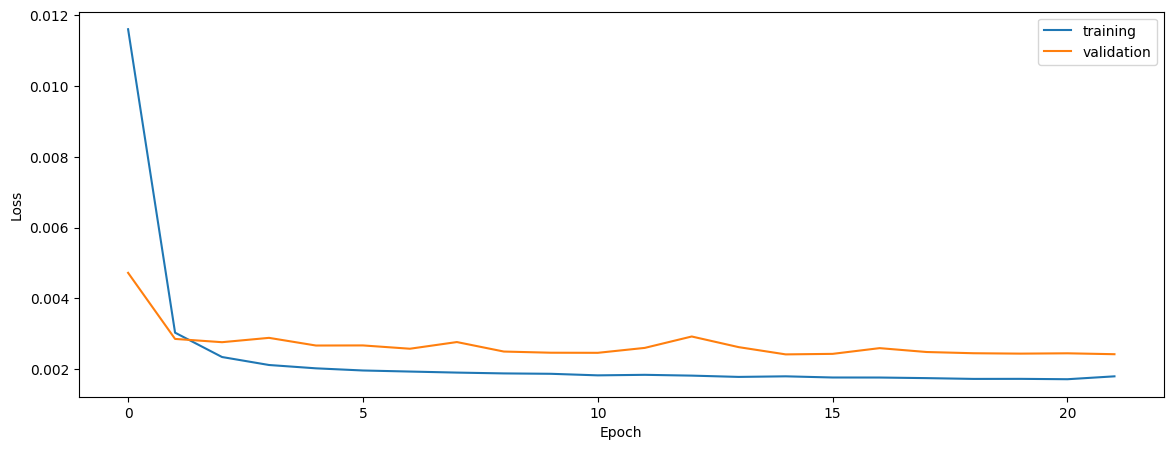

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


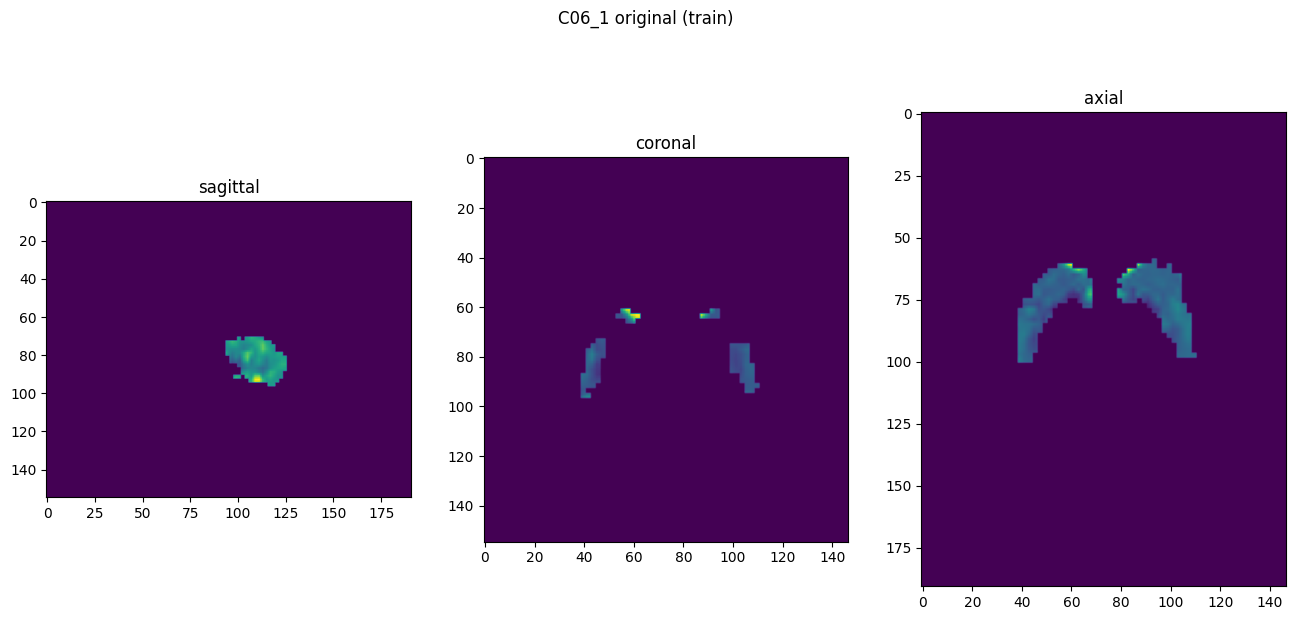

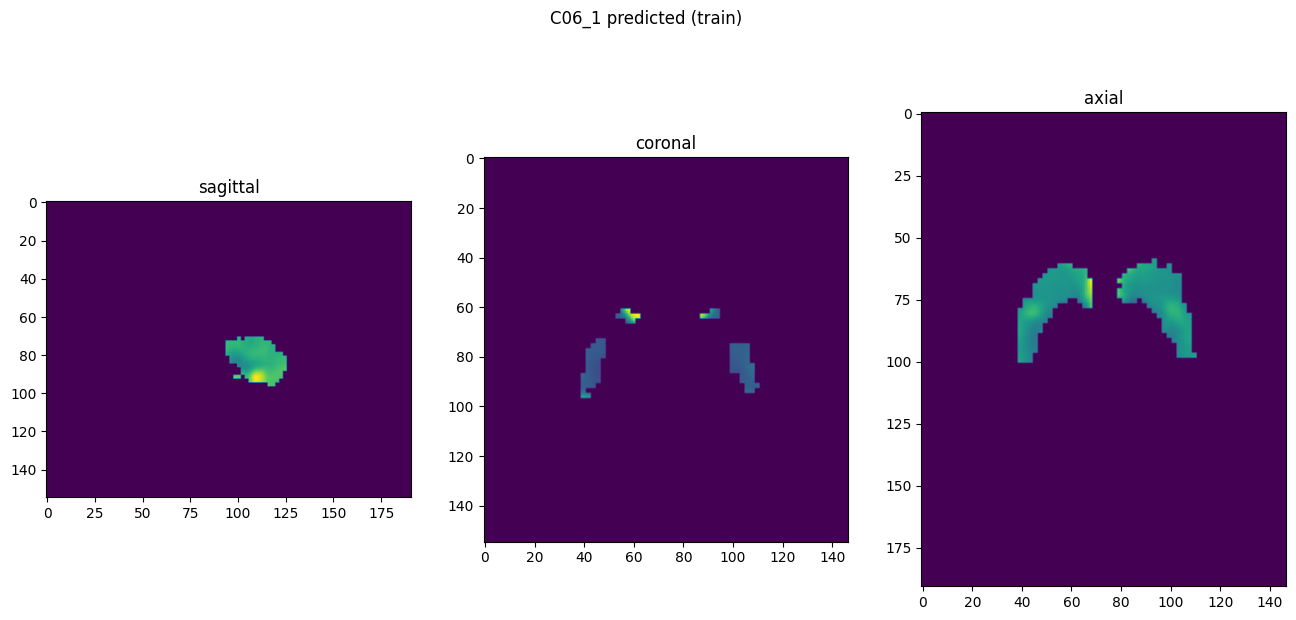

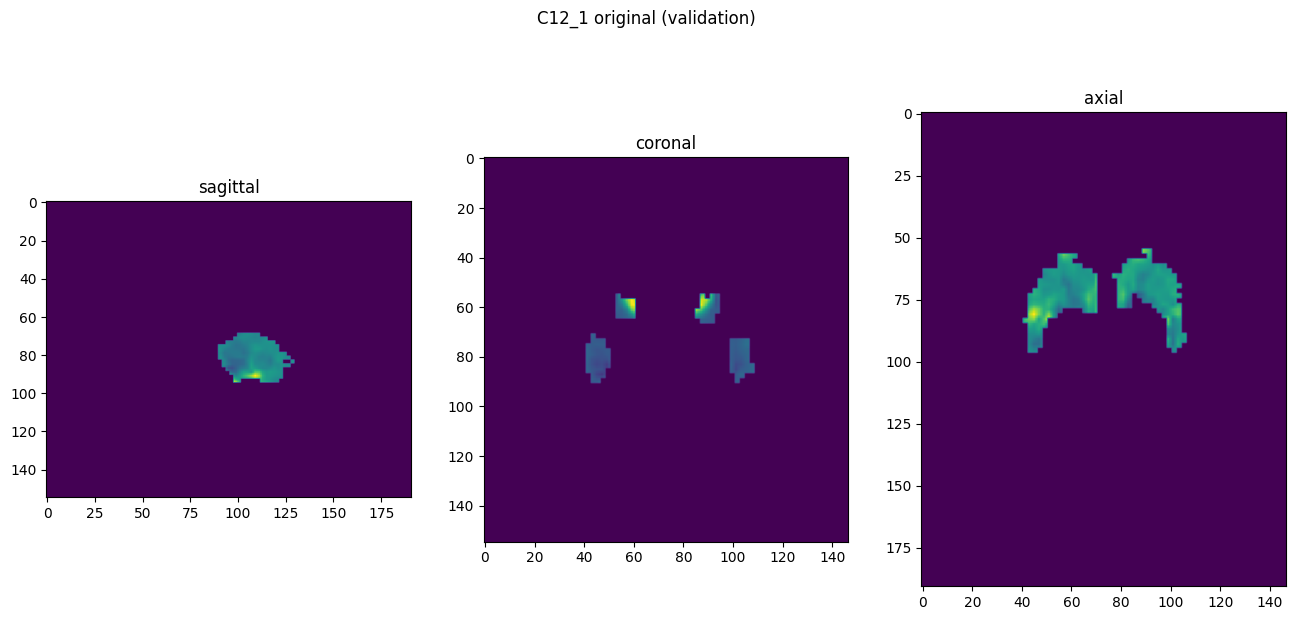

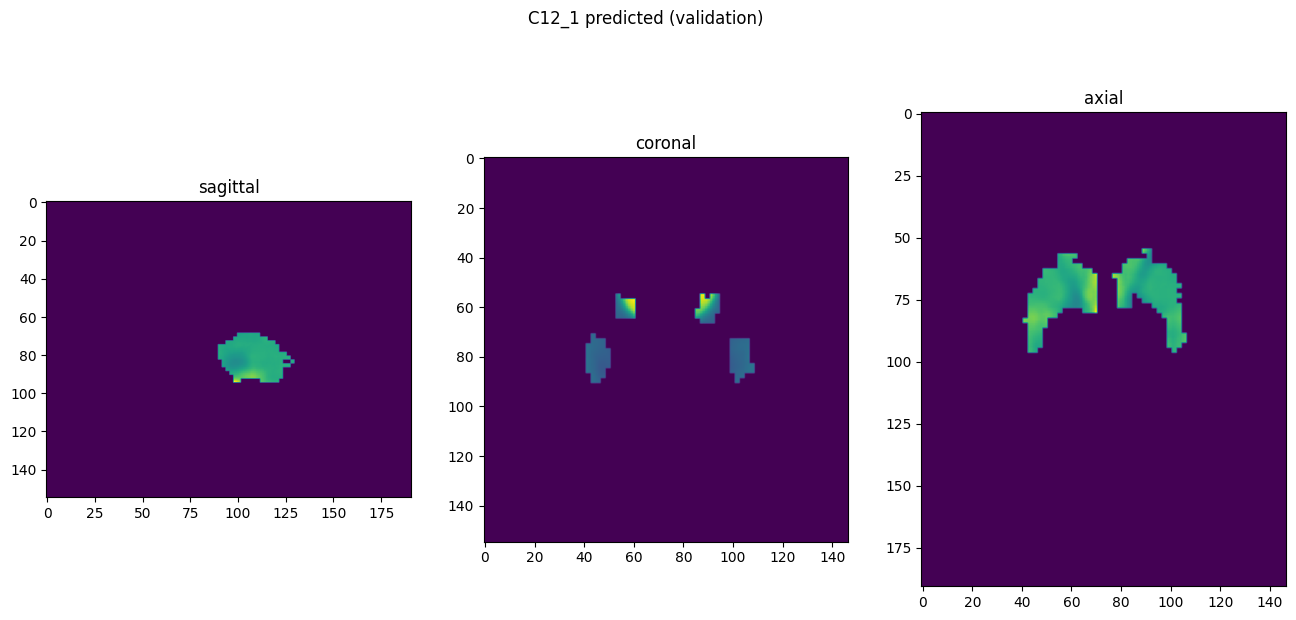

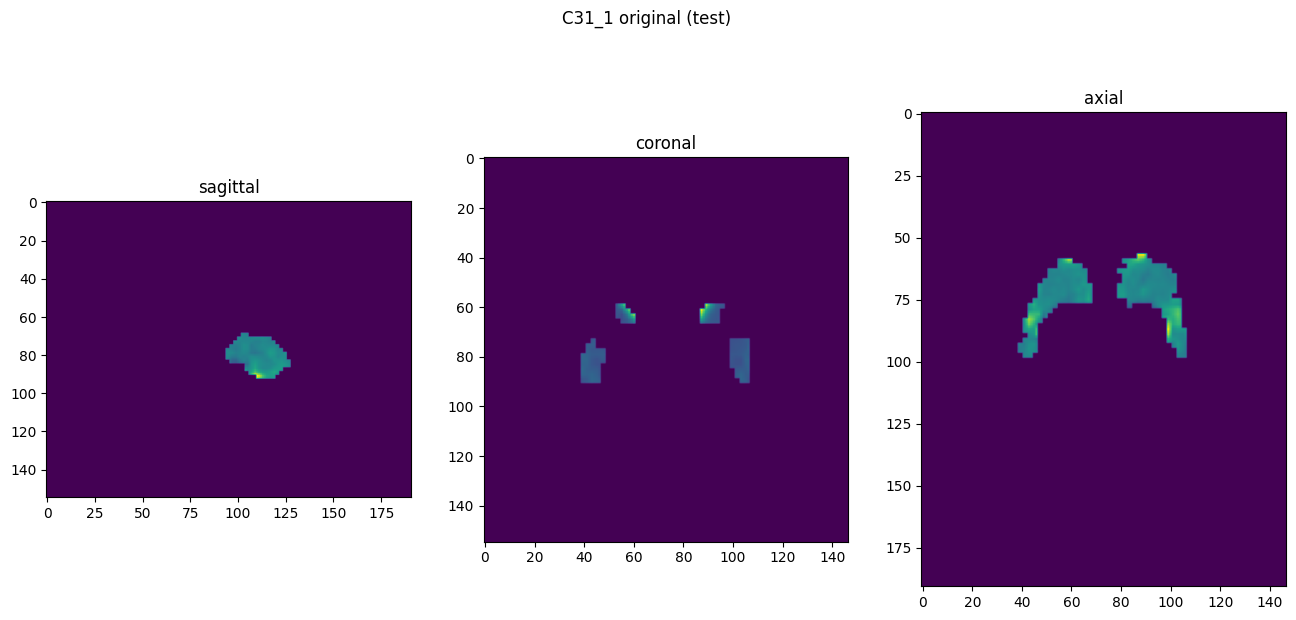

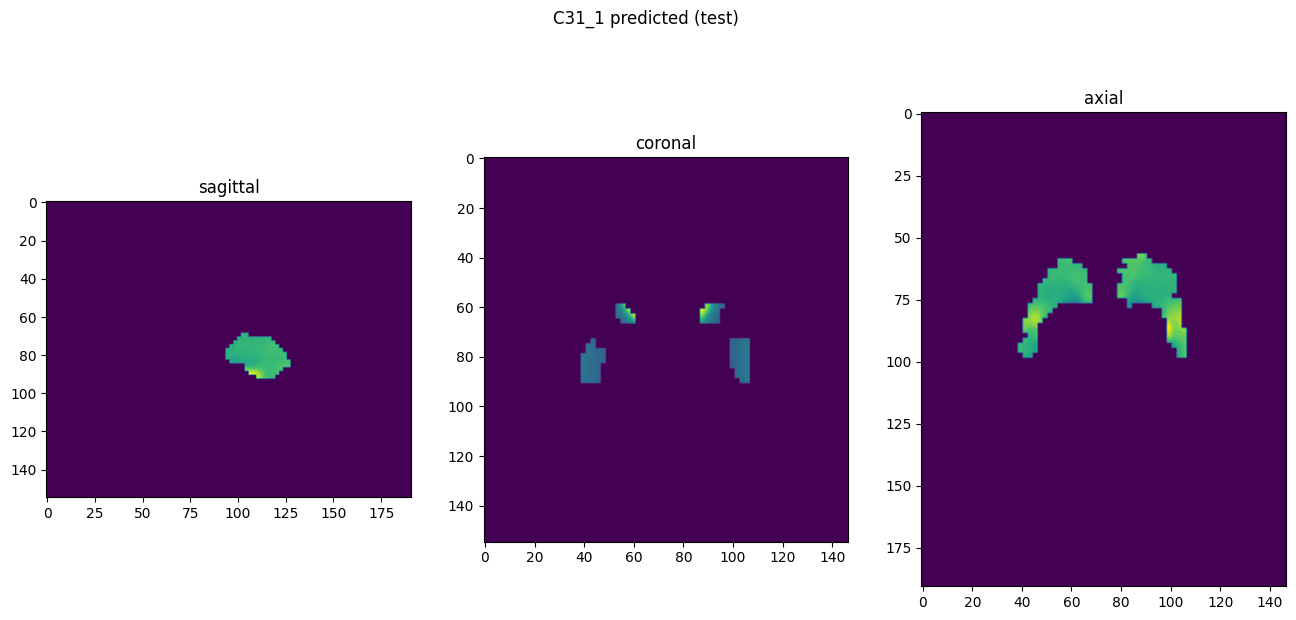

In [10]:
showResults(model, gen, threshold=None, background=False)